In [26]:
#Runs successfully on MBP 2024 metal_102 conda environment.
import numpy as np
import torch
import torch.nn as nn
import pymc as pm
import arviz as az
import pytensor.tensor as tt
from pytensor import scan
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
# Suppress PyTorch warnings
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Use CPU instead of GPU

In [159]:
# Define constants
SIZE = 200
T=200
dt=0.1
NUM_SAMPLES = 10000
EPOCHS = 1000

In [160]:
# Define the discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(128 * (SIZE // 4), 1)
        )

    def forward(self, x):
        return self.model(x.permute(0, 2, 1))

In [161]:
# Loss function for the discriminator
def discriminator_loss(real_output, fake_output):
    real_loss = nn.BCEWithLogitsLoss()(real_output, torch.ones_like(real_output))
    fake_loss = nn.BCEWithLogitsLoss()(fake_output, torch.zeros_like(fake_output))
    return real_loss + fake_loss

In [162]:
# Create and compile the discriminator
discriminator = Discriminator()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

In [163]:
import pytensor.tensor as tt
from pytensor.scan import scan
from pytensor.tensor.random.utils import RandomStream
import torch
import numpy as np

def pymc_sim_channel(params, T, dt, source="torch"):
    kc12, kc21, Fnoise, scale, offset, kco1, koc2, ko12, ko21 = params
    eps = 1e-10  # Small constant to avoid zero probabilities
    if source == "pymc":
        zero = tt.constant(0.0)
        one = tt.constant(1.0)
        
        # Convert parameters to PyTensor tensors
        """
        kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale = map(tt.as_tensor_variable, 
                                                                        [kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale])

        """
        kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale = map(lambda x: tt.maximum(tt.as_tensor_variable(x), eps), 
                                                                [kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale])
        # Create transition matrix
        row1 = tt.stack([1-kc12, kc12, zero, zero])
        row2 = tt.stack([kc21, 1-kc21-kco1, kco1, zero])
        row3 = tt.stack([zero, koc2, 1-koc2-ko12, ko12])
        row4 = tt.stack([zero, zero, ko21, 1-ko21])
        transition_matrix = tt.stack([row1, row2, row3, row4])

        transition_matrix = tt.maximum(transition_matrix, eps)
        row_sums = transition_matrix.sum(axis=1, keepdims=True)
        transition_matrix = transition_matrix / row_sums
        
        # Create a RandomStream for managing the RNG
        srng = RandomStream()
        
        # Generate random initial state
        initial_state = srng.categorical(tt.ones(4) / 4, size=(1,))
        
        def step(state, transition_probs):
            new_state = srng.categorical(transition_probs[state[0]], size=(1,))
            return new_state
        
        states, _ = scan(
            fn=step,
            outputs_info=initial_state,
            non_sequences=transition_matrix,
            n_steps=SIZE-1
        )
        
        states = tt.concatenate([initial_state, states.flatten()])
        
        # Convert states to channels
        channels = tt.switch(states < 2, zero, one)
        
        # Generate noise
        noise = srng.normal(0, Fnoise, size=(SIZE,))
        
        # Combine channels and noise
        result = tt.stack([channels, channels * scale + offset + noise], axis=-1)
        
        # Return the PyTensor variable directly
        return result


    else:
        # Convert to PyTorch tensors
        kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale = map(lambda x: torch.tensor(max(x, eps)), 
                                                                        [kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale])
        
        # Create transition matrix
        row1 = torch.tensor([1-kc12, kc12, 0, 0])
        row2 = torch.tensor([kc21, 1-kc21-kco1, kco1, 0])
        row3 = torch.tensor([0, koc2, 1-koc2-ko12, ko12])
        row4 = torch.tensor([0, 0, ko21, 1-ko21])
                
        transition_matrix = torch.stack([row1, row2, row3, row4])
        
        # Ensure non-negative values and add small constant
        transition_matrix = torch.clamp(transition_matrix, min=eps)
        
        # Normalize rows to sum to 1
        row_sums = transition_matrix.sum(dim=1, keepdim=True)
        transition_matrix = transition_matrix / row_sums
        
        def transition_fn(state):
            probs = transition_matrix[state]
            return torch.distributions.Categorical(probs=probs).sample()
        
        initial_probs = torch.ones(4) / 4  # Equal probability for all initial states
        initial_distribution = torch.distributions.Categorical(probs=initial_probs)
        
        states = [initial_distribution.sample().item()]
        
        for _ in range(SIZE - 1):
            states.append(transition_fn(states[-1]).item())
        
        channels = torch.tensor(states)
        channels = torch.where(channels < 2, torch.zeros_like(channels), torch.ones_like(channels))
        noise = torch.normal(0, Fnoise, (SIZE,))
        
        res = torch.stack([channels, channels * scale + offset + noise], axis=-1)
        return res

Text(0.5, 1.0, 'torch sim Channel Data')

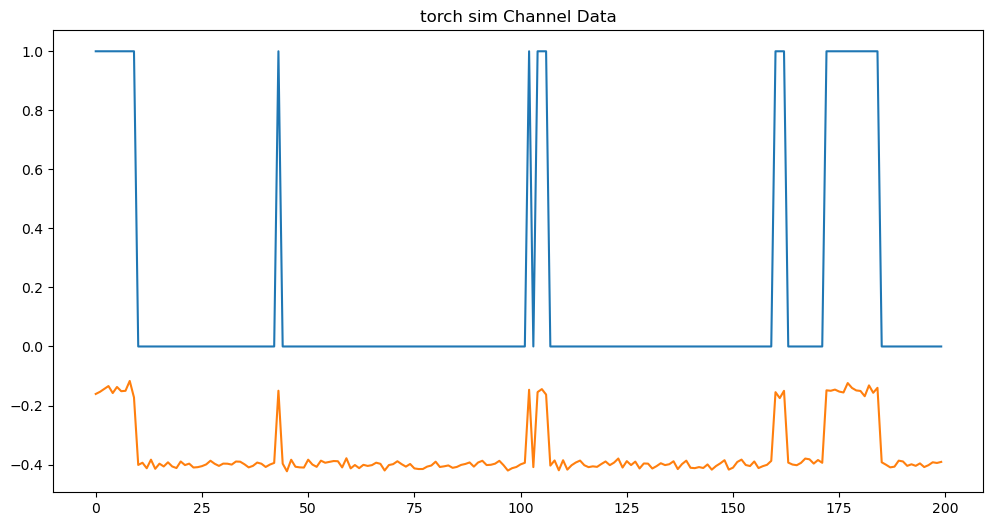

In [164]:
"""
    X  C1  C2  O1  O2
    C1  Z        
    C2      Z
    O1          Z
    O2              Z

"""
kc12=0.1
kc21=2
Fnoise=0.01
scale=0.25
offset=-0.4
kco1=0.5
kco2=0.25
ko12=1
ko21=2 

orig_params=[kc12,kc21,Fnoise,scale, offset,kco1,kco2,ko12,ko21]
plt.figure(figsize=(12, 6))
plt.plot(pymc_sim_channel(orig_params, T, dt))
plt.title('torch sim Channel Data')

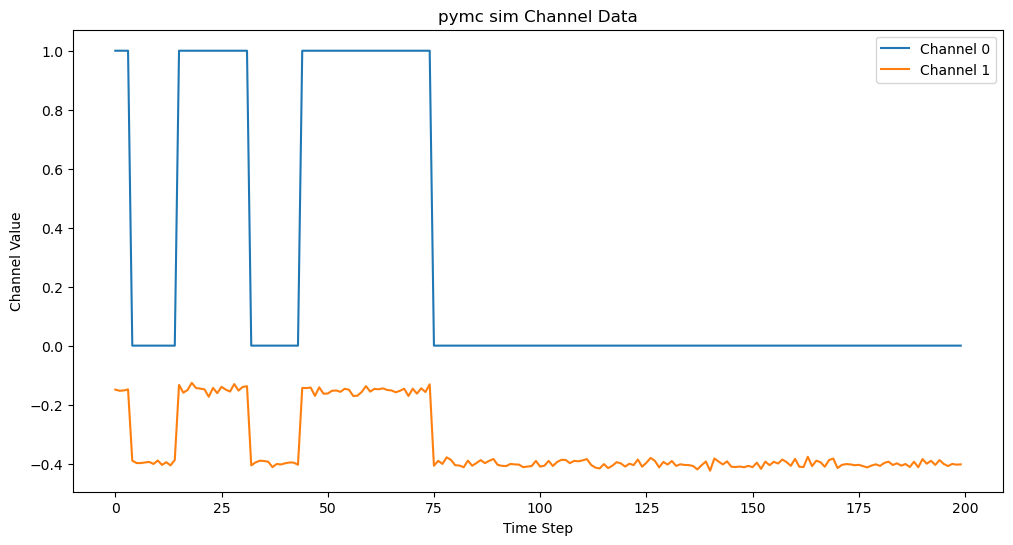

In [165]:
#Test our model
import pymc as pm
import pytensor.tensor as tt
import matplotlib.pyplot as plt
import pytensor

# Test our model
with pm.Model():
    # Convert orig_params to PyTensor variables
    params = [tt.as_tensor_variable(param) for param in orig_params]
    
    # Get the symbolic output from pymc_sim_channel
    channels_symb = pymc_sim_channel(orig_params, T, dt, source="pymc")
    
    # Create a PyTensor function to evaluate the symbolic output
    f = pytensor.function([], channels_symb)
    
    # Evaluate the function to get concrete values
    channels = f()

# Now plot the concrete values
plt.figure(figsize=(12, 6))
plt.plot(channels[:, 0], label='Channel 0')
plt.plot(channels[:, 1], label='Channel 1')
plt.legend()
plt.title('pymc sim Channel Data')
plt.xlabel('Time Step')
plt.ylabel('Channel Value')
plt.show()

In [166]:
real_data = torch.stack([pymc_sim_channel(orig_params, T, dt) for _ in range(NUM_SAMPLES)], dim=0)

In [167]:
with pm.Model() as model:
    # Priors for parameters
    kc21 = pm.Beta('kc21', alpha=2, beta=5)
    kc12 = pm.Beta('kc12', alpha=2, beta=5)
    kco1 = pm.Beta('kco1', alpha=2, beta=5)
    koc2 = pm.Beta('koc2', alpha=2, beta=5)
    ko12 = pm.Beta('ko12', alpha=2, beta=5)
    ko21 = pm.Beta('ko21', alpha=2, beta=5)
    Fnoise = pm.HalfNormal('Fnoise', sigma=1)
    scale = pm.HalfNormal('scale', sigma=1)
    offset = pm.Normal('offset', mu=0, sigma=1)
    """
    # Generate synthetic data
    synthetic_data = pm.Deterministic('synthetic_data', 
                                      pymc_sim_channel([kc12, kc21, Fnoise, scale, offset, kco1, koc2, ko12, ko21], T, dt, source="pymc"))
    """
    # Placeholder for discriminator score (will be updated during training)
    discriminator_score = pm.MutableData('discriminator_score', np.zeros((NUM_SAMPLES, 1)))  # Note the shape (NUM_SAMPLES, 1)

    # Likelihood based on discriminator score
    #pm.Bernoulli('likelihood', p=pm.math.sigmoid(discriminator_score), observed=np.ones((NUM_SAMPLES, 1)))
    pm.Normal('likelihood', mu=discriminator_score, sigma=1, observed=np.zeros((NUM_SAMPLES, 1)))

In [172]:
# Training loop
for epoch in tqdm(range(EPOCHS)):
    if epoch > 0:
        summary = az.summary(trace)
        print(summary)
        print (f"epoch {epoch}/{EPOCHS}")
        print(disc_loss)
    
    # Sample from the posterior
    with model:
        trace = pm.sample(500, tune=50, chains=8, cores=8)
    
    # Generate synthetic data using the samples
    synthetic_data = []
    for i in range(NUM_SAMPLES):
        # Sample a random set of parameters from the trace
        #idx = np.random.randint(len(trace))
        posterior = trace.posterior.stack(sample=['chain', 'draw'])
        
        params = [
            posterior['kc12'].mean().item(),
            posterior['kc21'].mean().item(),
            posterior['Fnoise'].mean().item(),
            posterior['scale'].mean().item(),
            posterior['offset'].mean().item(),
            posterior['kco1'].mean().item(),
            posterior['koc2'].mean().item(),
            posterior['ko12'].mean().item(),
            posterior['ko21'].mean().item()
        ]
        
        # Generate synthetic data using these parameters
        strip = pymc_sim_channel(params, T, dt, source="torch")
        synthetic_data.append(strip)   
    synthetic_data = torch.stack(synthetic_data)
    
    # Get discriminator loss   
    real_output = discriminator(real_data)
    fake_output = discriminator(synthetic_data)
    disc_loss = discriminator_loss(real_output, fake_output)
    if epoch % 10 == 0:
        #Occasionally train it so in berween pymc has a constant task to work against
        #Otherwise it MAY have a better solution but the loss greater anyway.
        #disc_losses.append(disc_loss.item())
        print("training")
        discriminator_optimizer.zero_grad()
        disc_loss.backward()
        discriminator_optimizer.step()

    # Calculate average discriminator loss
    #avg_disc_loss = np.mean(disc_losses)
    # Update the model's posterior using the discriminator's feedback
    with model:
        disc_score = -disc_loss.item() * np.ones((NUM_SAMPLES, 1))
        #fake_output_reshaped = fake_output.detach().numpy().reshape((NUM_SAMPLES, 1))
        #pm.set_data({'discriminator_score': fake_output_reshaped})
        pm.set_data({'discriminator_score': disc_score})
    
    clear_output(wait=True)

  8%|█████████▏                                                                                                  | 85/1000 [1:50:20<18:58:37, 74.66s/it]

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
offset -0.010  0.992  -1.763    1.973      0.016    0.014    3876.0    2887.0   
kc21    0.286  0.158   0.027    0.573      0.002    0.002    5171.0    2712.0   
kc12    0.287  0.160   0.018    0.569      0.002    0.002    4756.0    2618.0   
kco1    0.284  0.156   0.017    0.562      0.002    0.002    4746.0    2381.0   
koc2    0.286  0.160   0.025    0.574      0.002    0.002    5185.0    2640.0   
ko12    0.287  0.152   0.017    0.555      0.002    0.002    4992.0    2815.0   
ko21    0.284  0.155   0.021    0.563      0.002    0.002    4468.0    2728.0   
Fnoise  0.780  0.589   0.001    1.827      0.010    0.007    2212.0    1361.0   
scale   0.808  0.619   0.001    1.944      0.009    0.007    2743.0    1614.0   

        r_hat  
offset    1.0  
kc21      1.0  
kc12      1.0  
kco1      1.0  
koc2      1.0  
ko12      1.0  
ko21      1.0  
Fnoise    1.0  
scale     1.0  
epoch 85/1000
tensor(0.0807, 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [kc21, kc12, kco1, koc2, ko12, ko21, Fnoise, scale, offset]


Sampling 8 chains for 50 tune and 500 draw iterations (400 + 4_000 draws total) took 1 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
  8%|█████████▏                                                                                                  | 85/1000 [1:51:28<19:59:54, 78.68s/it]


KeyboardInterrupt: 

In [ ]:
# Final evaluation
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace)
az.plot_trace(trace)

In [ ]:
summary = az.summary(trace)
print(summary)

In [ ]:
# Extracting parameter names
parameter_names = summary.index.tolist()

# Iterating through parameter names
params=[]
for i, param in enumerate(parameter_names):
    mean_value = summary.loc[param, 'mean']
    params.append(mean_value)
    print(f"Parameter: {param}, Mean: {mean_value}")
    if i >= 5:
        break

In [ ]:
plt.plot(sim_channel([params[1],params[2],params[3],params[4],params[5],params[0]],T,dt))
plt.show()